In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q '/content/drive/My Drive/ComputerVision/MoA/lish-moa.zip'

In [ ]:
tr_fe=pd.read_csv('/content/train_features.csv')

In [ ]:
tr_fe.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [ ]:
tst_fe=pd.read_csv('/content/test_features.csv')
tst_fe.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,-0.3260,1.9390,-0.2305,-0.3670,1.3040,1.4610,0.0043,0.6816,-0.2304,-0.0635,-0.2030,-0.6821,-0.6242,0.1297,-0.0338,0.3372,0.2254,0.4795,0.7642,0.6638,-0.2480,-0.1183,-0.4847,-0.0179,-0.8204,-0.5296,-1.5070,-0.0144,...,-0.1353,0.0494,0.8939,0.2270,0.2876,-0.3065,0.6519,-0.8156,-1.4960,0.3796,0.0877,-1.0230,-0.0206,-0.4149,-0.6258,-0.2688,0.4403,-0.4900,0.2910,0.0473,-0.0914,0.3087,-0.0612,-0.9128,-0.9399,0.0173,0.0519,-0.0035,-0.5184,-0.3485,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,-0.3528,0.1271,0.9303,0.3173,-1.0120,-0.3213,0.0607,-0.5389,-0.8030,-1.0600,-0.0978,-0.8156,-0.6514,0.6812,0.5246,0.0000,0.5030,-0.1500,-0.1433,2.0910,-0.6556,-0.6012,-0.4104,-0.0580,-0.3608,0.2197,-0.7101,1.3430,...,-0.7458,0.0458,-0.3644,-1.8180,-0.0358,-0.7925,-0.2693,-0.0938,-0.1833,-0.7402,-1.4090,0.1987,0.0460,-1.3520,-0.3445,-0.0909,-0.6337,-0.5788,-0.7885,0.0996,-1.9480,-1.2720,-0.7223,-0.5838,-1.3620,-0.7671,0.4881,0.5913,-0.4333,0.1234,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,-0.3206,0.6944,0.5837,-0.0553,-0.6222,2.5430,-0.7857,0.8163,-0.0495,0.1806,1.0290,-0.5204,-1.1070,0.7365,-0.3835,-0.5771,0.0523,-0.2690,0.1674,0.6010,-0.6660,0.0276,0.0924,0.2785,-0.3943,-0.4602,-0.0673,-1.3420,0.3127,...,0.4369,-1.4960,1.2390,-1.2220,0.6624,-0.7336,-0.5248,0.0727,0.1455,0.5364,-0.0823,0.5734,0.4876,0.7088,1.0750,0.4689,1.0870,-0.5036,-0.3451,0.5087,1.1100,0.7886,0.2093,-0.4617,1.4870,0.1985,1.1750,-0.5693,0.5062,-0.1925,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,0.9365,0.2942,1.3990,-1.1080,1.1610,-0.8134,0.0743,-0.3096,-0.9956,1.7100,1.2200,-0.1258,-0.5900,-0.7956,-0.6765,0.0000,-0.8820,0.7609,-0.0882,0.5217,0.9587,-0.4764,0.2690,0.4753,0.0196,0.2775,-0.7142,0.7079,...,-1.2190,-0.5564,-0.2831,0.5902,-0.2881,-0.0013,-0.4036,-0.4076,-0.5593,-0.5505,-0.4806,-0.0846,0.5884,0.2310,0.3956,0.6495,-0.2511,-0.2207,0.1274,-0.5378,0.5649,-0.1231,0.1586,-0.4260,-0.6815,-0.4753,0.2611,-1.1780,0.1909,-1.2320,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,0.2611,-1.1120,-0.1747,-0.2053,-0.0006,0.0254,0.1784,-0.1314,1.0700,0.0477,-0.0756,0.1287,0.1403,0.7609,-0.1095,0.0000,-1.0950,-0.0780,0.9048,-0.3007,0.4351,-0.1558,0.2101,0.4850,0.1139,0.6745,-0.9101,-0.6690,...,0.6412,0.2123,0.0646,0.5924,0.5284,-0.4421,0.6547,-0.8098,0.9812,-0.0349,0.7816,1.1690,0.4140,1.0250,0.8642,0.5993,0.2091,-0.1521,1.5610,-0.6770,0.3600,-0.1436,-0.0949,1.0640,0.8321,0.9727,-0.5567,0.2240,0.8949,0.8668,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [ ]:
tr_fe.isnull().sum()

sig_id     0
cp_type    0
cp_time    0
cp_dose    0
g-0        0
          ..
c-95       0
c-96       0
c-97       0
c-98       0
c-99       0
Length: 876, dtype: int64

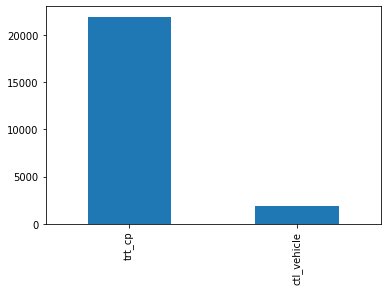

In [ ]:
tr_fe.cp_type.value_counts().plot(kind='bar')
plt.show()

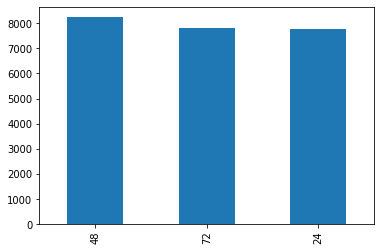

In [ ]:
tr_fe.cp_time.value_counts().plot(kind='bar')
plt.show()

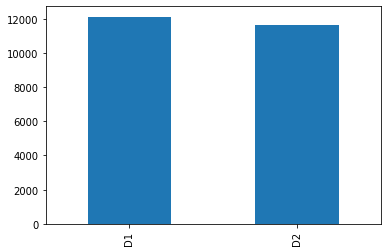

In [ ]:
tr_fe.cp_dose.value_counts().plot(kind='bar')
plt.show()

In [ ]:
tr_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [ ]:
tr_tar=pd.read_csv('/content/train_targets_scored.csv')
tr_tar.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
for col in tr_tar.columns:
    tr_tar[col].value_counts().plot(kind='bar')
    plt.show()

In [ ]:
x1=tr_fe.drop(columns=['sig_id'])

In [ ]:
enc_cols=['cp_dose','cp_type']
 
 
enc_data=pd.get_dummies(x1[enc_cols])
 
enc_data.head()

,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,0,1,0,1


In [ ]:
x1=x1.drop(columns=enc_cols, axis=1)

In [ ]:
enc_data_tr=pd.concat([x1,enc_data],axis=1)

In [ ]:
enc_data_tr.head()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,24,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,0,0,1
1,72,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,...,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,1,0,0,1
2,48,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,...,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,1,0,0,1
3,48,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,3.0900,...,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,1,0,0,1
4,72,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0,1,0,1


In [ ]:
x=enc_data_tr.copy()
x.head()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,24,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,0,0,1
1,72,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,...,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,1,0,0,1
2,48,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,...,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,1,0,0,1
3,48,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,3.0900,...,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,1,0,0,1
4,72,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0,1,0,1


In [ ]:
y=tr_tar.drop(['sig_id'], axis=1)
y.shape

(23814, 206)

In [ ]:
x.shape

(23814, 877)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as f
import torch.optim as optim

In [ ]:
dev='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class NN(nn.Module):
    def __init__(self, inp,out):
        super(NN,self).__init__()
        self.linear=nn.Linear(inp,out)
    def forward(self, inp):
        inp=f.sigmoid(self.linear(inp))
        return inp

In [ ]:
 def nn_train(model, d_ldr, epochs, criterion,opt):
        tr_loss=[]
        model.train()
        for e in range(epochs):
          temp_loss=0
          print( 'epoch:',e)
          for data, lbl in d_ldr:
                 data=data.to(dev)
                 lbl=lbl.to(dev)
                 opt.zero_grad()
                 out=model(data)
                 
                 loss=criterion(out, lbl)
                 loss.backward()
                 opt.step()
                 del out, data, lbl
                 torch.cuda.empty_cache()
                 temp_loss+=loss.item()
          temp_loss=temp_loss/len(d_ldr) 
          print('loss',temp_loss)
          tr_loss.append(temp_loss)
        #cp={'state_dict': model.state_dict()}
        #torch.save(cp, 'Checkpoint.pth')     
        return tr_loss, model
 
def nn_eval(model, tst_ldr,criterion):
         tst_loss=[]
         true=0
         total=0
         model.eval()
         for data, lbl in tst_ldr:
            data=data.to(dev)
            lbl=lbl.to(dev)
            out=model(data)
            loss =criterion(out, lbl)
            _, pred=torch.max(out.data,1)
            total+=loss.item()
         tst_loss=total/len(tst_ldr)
         print('val loss',tst_loss)
         return tst_loss,pred

In [ ]:
model=NN(x.shape[1],y.shape[1]).to(dev)

In [ ]:
criterion=nn.BCELoss()
opt=optim.Adam(model.parameters(),lr=.01)

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
def getCustomDataLoader(x,y):
   tenX=torch.tensor(x.values, dtype=torch.float)
   tenY=torch.tensor(y.values,dtype=torch.float)
   ds=TensorDataset (tenX,tenY)
   dl=DataLoader(ds,batch_size=20,shuffle=False)
   return dl

In [ ]:
cv=RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)
 
for tr_ind, tst_ind in cv.split(x):
   #print(tr_ind, tst_ind)
 
   x_train, x_val=x.loc[tr_ind],x.loc[tst_ind]
   y_train, y_val=y.loc[tr_ind], y.loc[tst_ind]
   n_inp=x.shape[1]
   n_out=y.shape[1]
   tr_dl=getCustomDataLoader(x_train,y_train)
   val_dl=getCustomDataLoader(x_val,y_val)
   tr_loss,model=nn_train(model,tr_dl,20, criterion,opt)
   val_loss,pred=nn_eval(model,val_dl, criterion)

epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss 0.05185222649102363
epoch: 1
loss 0.05109860026277602
epoch: 2
loss 0.048665142517342275
epoch: 3
loss 0.04598377553925071
epoch: 4
loss 0.03476988809763579
epoch: 5
loss 0.0325385131134735
epoch: 6
loss 0.030918004309650818
epoch: 7
loss 0.030870472612259076
epoch: 8
loss 0.030224781218871
epoch: 9
loss 0.02981967814640253
epoch: 10
loss 0.02780350340042027
epoch: 11
loss 0.027467411085302984
epoch: 12
loss 0.02633347643544522
epoch: 13
loss 0.027220689153616705
epoch: 14
loss 0.026145174104521406
epoch: 15
loss 0.02705944461140733
epoch: 16
loss 0.0256862223800793
epoch: 17
loss 0.02611915536577563
epoch: 18
loss 0.02525941104999111
epoch: 19
loss 0.025251159893823164
val loss 0.14841489689424633
epoch: 0
loss 0.04451012213231384
epoch: 1
loss 0.03924588810831896
epoch: 2
loss 0.037413957906250996
epoch: 3
loss 0.03672872393041477
epoch: 4
loss 0.035225482822075285
epoch: 5
loss 0.03519358182974931
epoch: 6
loss 0.034591634883462806
epoch: 7
loss 0.035140107496528204
epoch: 8
lo

In [ ]:
x2=tst_fe.drop(columns=['sig_id'])
x2.shape

(3982, 875)

In [ ]:
 enc_cols=['cp_dose','cp_type']
 
 
enc_data_tst=pd.get_dummies(x2[enc_cols])
 
enc_data_tst.head()

,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,1,0,0,1
1,1,0,0,1
2,1,0,1,0
3,0,1,0,1
4,1,0,0,1


In [ ]:
x2=x2.drop(columns=enc_cols, axis=1)
x2.shape

(3982, 873)

In [ ]:
x_tst=pd.concat([x2,enc_data_tst],axis=1)
print(x_tst.shape)
ten_tst=torch.tensor(x_tst.values, dtype=torch.float)
#tst_ds=TensorDataset (ten_tst)
tst_dl=DataLoader(ten_tst,batch_size=32,shuffle=False)
predlist=[]
with torch.no_grad():
  for i,data in enumerate (tst_dl):
    
      data=data.to(dev)
      out=model(data)
      #pred=out.cpu().numpy()
      #print(out.data)
      #_, pred=torch.max(out.data,1)
      #print(pred)
      predlist.extend(out.data.numpy())

(3982, 877)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
len(predlist)

3982

In [ ]:
ss=pd.read_csv('/content/sample_submission.csv')
ss.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,id_00276f245,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,id_0027f1083,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
ss.iloc[:,1:]=predlist
ss.to_csv('submission.csv',index=False)
ss.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,2.771889e-34,0.0,4.060713e-32,0.0,4.172949e-07,0.000000e+00,0.0,0.0,4.377982e-25,0.000000e+00,5.966854e-09,0.000000e+00,1.028850e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.082272e-16,0.0,0.0,1.412973e-14,1.353654e-29,0.0,9.580470e-39,0.000000e+00,3.744065e-29,0.000000e+00,5.395318e-30,0.0,5.402227e-34,0.000000e+00,0.0,1.792028e-21,9.977034e-14,6.261879e-30,1.795743e-37,0.0,0.0,...,0.000000e+00,0.0,4.718947e-31,0.000000e+00,8.065058e-35,0.0,3.085737e-27,2.119593e-31,0.000000e+00,0.0,0.000000e+00,1.393001e-08,1.695786e-27,0.0,0.0,0.000000e+00,0.0,0.0,0.0,9.321169e-23,0.000000e+00,0.0,0.000000e+00,2.320852e-37,1.017766e-28,0.000000e+00,0.0,0.0,0.0,0.0,6.482972e-37,1.857662e-17,0.0,0.0,0.0,0.000000e+00,0.0,1.414225e-20,1.338859e-35,0.0
1,id_001897cda,0.000000e+00,0.0,0.000000e+00,0.0,7.250203e-15,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.621564e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.457320e-29,0.000000e+00,0.000000e+00,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,4.464457e-14,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
2,id_002429b5b,0.000000e+00,0.0,0.000000e+00,0.0,6.224188e-20,0.000000e+00,0.0,0.0,1.120341e-28,0.000000e+00,2.995357e-18,0.000000e+00,1.538522e-27,0.000000e+00,6.010096e-32,0.000000e+00,5.910958e-26,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.679731e-38,0.000000e+00,9.817789e-28,0.000000e+00,0.000000e+00,0.0,0.000000e+00,5.566730e-31,0.0,1.975396e-19,1.015821e-12,0.000000e+00,0.000000e+00,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.439390e-33,0.0,5.122019e-15,3.729607e-38,0.000000e+00,0.0,1.108092e-35,3.411582e-16,0.000000e+00,0.0,0.0,4.745954e-31,0.0,0.0,0.0,1.284710e-25,0.000000e+00,0.0,1.388765e-30,0.000000e+0